# 脚本介绍
将chatTTS的语音通过RVC进行换声
并且将中间特征和换声后的Mel频谱图保存下来
以便用于训练音色固定的模型

In [1]:
## 前置依赖
import random
import wave
import numpy as np
import torchaudio
import ChatTTS
from scipy.io.wavfile import write
import librosa

# from zh_normalization import TextNormalizer
import logging
import torch
import os
from IPython.display import Audio

torch._dynamo.config.cache_size_limit = 64
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')
logging.basicConfig(level=logging.DEBUG)


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 加载chaTTS模型

In [2]:
from modelscope import snapshot_download
model_dir = snapshot_download('mirror013/ChatTTS')

# 加载模型
chat = ChatTTS.Chat()
chat.load_models(
    source="local",
    local_path=model_dir,
    device='cpu',
    compile=False,
)

SEED = 1397
torch.manual_seed(SEED) # 音色种子
# load from local file if exists
if os.path.exists('spk_emb.npy'):
    spk_emb = torch.load('spk_emb.npy',map_location='cpu')
else:
    spk_emb = chat.sample_random_speaker()

params_infer_code = {
    'spk_emb': spk_emb,
    'temperature': 0.1,
    'top_P': 0.7,
    'top_K': 20,
}

params_refine_text = {'prompt': '[oral_0][laugh_0][break_0]'}

text = "接下来,杨叔，借我看一下现场地图。他肯定穿过了前面的那扇门，不可能在这么小的地方晃悠了两小时。" # 该文本仅作测试用途

2024-06-21 16:43:17,389 - modelscope - INFO - PyTorch version 2.1.0 Found.
2024-06-21 16:43:17,391 - modelscope - INFO - Loading ast index from /Users/charslee/.cache/modelscope/ast_indexer
2024-06-21 16:43:17,435 - modelscope - INFO - Loading done! Current index file version is 1.13.3, with md5 8e4efa69aee288a831cd8dd27b421a93 and a total number of 972 components indexed
INFO:ChatTTS.core:Load from local: /Users/charslee/.cache/modelscope/hub/mirror013/ChatTTS
INFO:ChatTTS.core:vocos loaded.
INFO:ChatTTS.core:dvae loaded.
INFO:ChatTTS.core:gpt loaded.
INFO:ChatTTS.core:decoder loaded.
INFO:ChatTTS.core:tokenizer loaded.
INFO:ChatTTS.core:All initialized.


### RVC 依赖函数

In [3]:
from scipy.io import wavfile
from fairseq import checkpoint_utils
import torchaudio
from lib.audio import load_audio
from lib.infer_pack.models import (
    SynthesizerTrnMs256NSFsid,
    SynthesizerTrnMs256NSFsid_nono,
    SynthesizerTrnMs768NSFsid,
    SynthesizerTrnMs768NSFsid_nono,
)
from vc_infer_pipeline import VC
from multiprocessing import cpu_count
import numpy as np
import torch
import sys
import glob
import argparse
import os
import sys
import pdb
import torch

now_dir = os.getcwd()
sys.path.append(now_dir)

using_cli = False
device = "cuda:0" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
is_half = False

    
if device == 'mps':
    # 设置环境变量 PYTORCH_ENABLE_MPS_FALLBACK=1
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# 只在jupyter notebook中运行
from IPython import get_ipython
if get_ipython() is not None:
    %set_env PYTORCH_ENABLE_MPS_FALLBACK=1
    pass

class Config:
    def __init__(self, device, is_half):
        self.device = device
        self.is_half = is_half
        self.n_cpu = 0
        self.gpu_name = None
        self.gpu_mem = None
        self.x_pad, self.x_query, self.x_center, self.x_max = self.device_config()

    def device_config(self) -> tuple:
        if torch.cuda.is_available() and device != "cpu":
            i_device = int(self.device.split(":")[-1])
            self.gpu_name = torch.cuda.get_device_name(i_device)
            if (
                ("16" in self.gpu_name and "V100" not in self.gpu_name.upper())
                or "P40" in self.gpu_name.upper()
                or "1060" in self.gpu_name
                or "1070" in self.gpu_name
                or "1080" in self.gpu_name
            ):
                print("16系/10系显卡和P40强制单精度")
                self.is_half = False
                for config_file in ["32k.json", "40k.json", "48k.json"]:
                    with open(f"configs/{config_file}", "r") as f:
                        strr = f.read().replace("true", "false")
                    with open(f"configs/{config_file}", "w") as f:
                        f.write(strr)
                with open("trainset_preprocess_pipeline_print.py", "r") as f:
                    strr = f.read().replace("3.7", "3.0")
                with open("trainset_preprocess_pipeline_print.py", "w") as f:
                    f.write(strr)
            else:
                self.gpu_name = None
            self.gpu_mem = int(
                torch.cuda.get_device_properties(i_device).total_memory
                / 1024
                / 1024
                / 1024
                + 0.4
            )
            if self.gpu_mem <= 4:
                with open("trainset_preprocess_pipeline_print.py", "r") as f:
                    strr = f.read().replace("3.7", "3.0")
                with open("trainset_preprocess_pipeline_print.py", "w") as f:
                    f.write(strr)
        elif torch.backends.mps.is_available():
            print("没有发现支持的N卡, 使用MPS进行推理")
            self.device = "mps"
        else:
            print("没有发现支持的N卡, 使用CPU进行推理")
            self.device = "cpu"
            self.is_half = False

        if self.n_cpu == 0:
            self.n_cpu = cpu_count()

        if self.is_half:
            # 6G显存配置
            x_pad = 3
            x_query = 10
            x_center = 60
            x_max = 65
        else:
            # 5G显存配置
            x_pad = 1
            x_query = 6
            x_center = 38
            x_max = 41

        if self.gpu_mem != None and self.gpu_mem <= 4:
            x_pad = 1
            x_query = 5
            x_center = 30
            x_max = 32

        return x_pad, x_query, x_center, x_max


config = Config(device, is_half)
now_dir = os.getcwd()
sys.path.append(now_dir)

hubert_model = None


def load_hubert():
    global hubert_model
    models, _, _ = checkpoint_utils.load_model_ensemble_and_task(
        ["hubert_base.pt"],
        suffix="",
    )
    hubert_model = models[0]
    hubert_model = hubert_model.to(config.device)
    if config.is_half:
        hubert_model = hubert_model.half()
    else:
        hubert_model = hubert_model.float()
    hubert_model.eval()


def vc_single(
    sid=0,
    audio=None, # 需要确保是16000采样率
    f0_up_key=0,
    f0_file=None,
    f0_method="rmvpe",
    file_index="",  # .index file
    file_index2="",
    # file_big_npy,
    index_rate=1.0,
    filter_radius=3,
    resample_sr=0,
    rms_mix_rate=0,
    model_path="",
    output_path="",
    protect=0.33,
):
    
    global tgt_sr, net_g, vc, hubert_model, version
    get_vc(model_path)
    if audio is None:
        raise "You need to upload an audio file"
    if not isinstance(audio,np.ndarray):
        raise "Make sure audio is a numpy array"

    f0_up_key = int(f0_up_key)
    audio_max = np.abs(audio).max() / 0.95

    if audio_max > 1:
        audio /= audio_max
    times = [0, 0, 0]

    if hubert_model == None:
        load_hubert()

    if_f0 = cpt.get("f0", 1)

    file_index = (
        (
            file_index.strip(" ")
            .strip('"')
            .strip("\n")
            .strip('"')
            .strip(" ")
            .replace("trained", "added")
        )
        if file_index != ""
        else file_index2
    )

    audio_opt = vc.pipeline(
        hubert_model,
        net_g,
        sid,
        audio,
        "",
        times,
        f0_up_key,
        f0_method,
        file_index,
        # file_big_npy,
        index_rate,
        if_f0,
        filter_radius,
        tgt_sr,
        resample_sr,
        rms_mix_rate,
        version,
        f0_file=f0_file,
        protect=protect,
        ret_audio_opt=True,
    )
    return audio_opt


def get_vc(model_path):
    global n_spk, tgt_sr, net_g, vc, cpt, device, is_half, version
    print("loading pth %s" % model_path)
    cpt = torch.load(model_path, map_location="cpu")
    tgt_sr = cpt["config"][-1]
    cpt["config"][-3] = cpt["weight"]["emb_g.weight"].shape[0]  # n_spk
    if_f0 = cpt.get("f0", 1)
    version = cpt.get("version", "v1")
    if version == "v1":
        if if_f0 == 1:
            net_g = SynthesizerTrnMs256NSFsid(*cpt["config"], is_half=is_half)
        else:
            net_g = SynthesizerTrnMs256NSFsid_nono(*cpt["config"])
    elif version == "v2":
        if if_f0 == 1:
            net_g = SynthesizerTrnMs768NSFsid(*cpt["config"], is_half=is_half)
        else:
            net_g = SynthesizerTrnMs768NSFsid_nono(*cpt["config"])
    del net_g.enc_q
    print(net_g.load_state_dict(cpt["weight"], strict=False))
    net_g.eval().to(device)
    if is_half:
        net_g = net_g.half()
    else:
        net_g = net_g.float()
    vc = VC(tgt_sr, config)
    n_spk = cpt["config"][-3]

INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.


env: PYTORCH_ENABLE_MPS_FALLBACK=1
没有发现支持的N卡, 使用MPS进行推理


In [4]:
# 定义RVC一些参数
f0_up_key = 0
model_path = "weights/three_moon_e20_s10000.pth"
file_index = ''
f0_method = 'rmvpe'

# 开始从chatTTS合成声音并且通过RVC进行转换

In [5]:
# 从chatTTS中获取音频信号
torch.manual_seed(SEED)
chat_result = chat.infer_debug(text=text, params_infer_code=params_infer_code)

audio_numpy = chat_result['wav'][0]
hidden = chat_result['hiddens'][0]
print(f"audio numpy shape: {audio_numpy.shape} and hidden shape: {hidden.shape}")
Audio(audio_numpy, rate=24000)

INFO:ChatTTS.core:All initialized.
 16%|█▌        | 324/2048 [00:16<01:27, 19.78it/s]


audio numpy shape: (1, 165632) and hidden shape: torch.Size([324, 768])


In [6]:
# 需要对音频进行重采样
resample_audio = librosa.resample(audio_numpy, orig_sr=24000, target_sr=16000)[0]
print(resample_audio.shape)

(110422,)


In [7]:

# 获取换声后的音频信号
audio_opt = vc_single(
        sid=0,
        audio=resample_audio,
        f0_up_key=f0_up_key,
        f0_file=None,
        f0_method=f0_method,
        file_index=file_index,
        file_index2="",
        index_rate=1,
        filter_radius=3,
        resample_sr=24000,
        rms_mix_rate=1,
        model_path=model_path,
        protect = 0.33,  # 不开启撕裂，电音保护
    )

# 打印audio_opt 最大值和最小值
print(f"audio_opt shape = {audio_opt.shape}max= {audio_opt.max()} and min = {audio_opt.min()}")

loading pth weights/three_moon_e20_s10000.pth


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


gin_channels: 256 self.spk_embed_dim: 109
<All keys matched successfully>


INFO:fairseq.tasks.hubert_pretraining:current directory is /private/tmp/RVC-ChatTTS
INFO:fairseq.tasks.hubert_pretraining:HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
INFO:fairseq.models.hubert.hubert:HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0.1, 'final_dim': 256, 'untie_final_proj': True, 'layer_norm_first': False, 'conv_featur

Parameters of the 'pipeline' function:
sid: 0
audio: [-5.0958231e-05 -6.9872345e-05 -6.6835782e-05 ...  1.8133329e-05
  2.7920241e-05  0.0000000e+00]
input_audio_path: 
times: [0, 0, 0]
f0_up_key: 0
f0_method: rmvpe
file_index: 
index_rate: 1
if_f0: 0
filter_radius: 3
tgt_sr: 40000
resample_sr: 24000
rms_mix_rate: 1
version: v2
protect: 0.33
f0_file: None
+---------------------------------------+


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/fairseq/utils.py:744: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:283.)
  tensor[indices] = value
/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:26: UserWarning: The operator 'aten::_weight_norm_interface' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return _weight_norm(v, g, self.dim)
/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/functional.py:3981: UserWarning: MPS: passing scale factor to upsample ops is supported natively starting from macOS 13.0. 

audio_opt shape = (165120,)max= 0.7640527486801147 and min = -0.6019341349601746


In [8]:
print(audio_opt.shape)
Audio(audio_opt, rate=24000)

(165120,)


# 对换声后的音频进行逆操作回Mel频谱图

In [9]:
# 将音频信号转化回Mel频谱图
# 重新加载回mel频谱图
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=24000,
    n_fft=1024,
    hop_length=256,
    n_mels=100,
    center=True,
    power=1,
)

def safe_log(x: torch.Tensor, clip_val: float = 1e-7) -> torch.Tensor:
    """
    Computes the element-wise logarithm of the input tensor with clipping to avoid near-zero values.

    Args:
        x (Tensor): Input tensor.
        clip_val (float, optional): Minimum value to clip the input tensor. Defaults to 1e-7.

    Returns:
        Tensor: Element-wise logarithm of the input tensor with clipping applied.
    """
    return torch.log(torch.clip(x, min=clip_val))

log_mel_spec shape: torch.Size([100, 646])


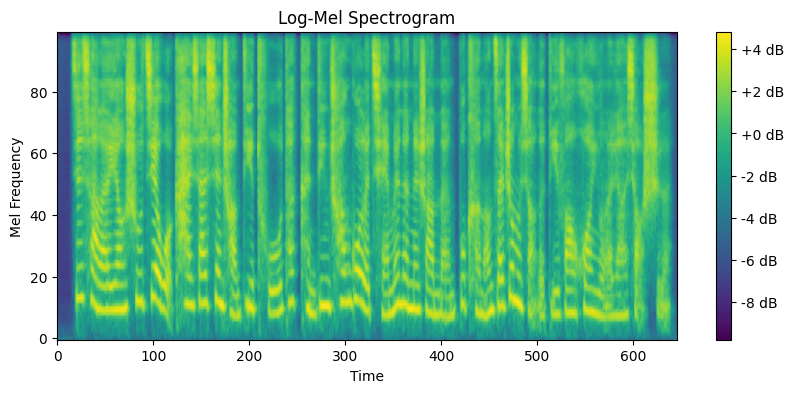

In [10]:
# 打印Mel频谱图
from matplotlib import pyplot as plt

# 可能需要进一步处理，比如取对数、缩放等，以便于可视化或后续处理
log_mel_spec = mel_spec(torch.from_numpy(audio_opt))
log_mel_spec = safe_log(log_mel_spec)
print(f"log_mel_spec shape: {log_mel_spec.shape}")

plt.figure(figsize=(10, 4))
plt.imshow(log_mel_spec, aspect='auto', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [11]:
# 将训练数据保存在本地
filename = "train001.npz"
if not isinstance(hidden,np.ndarray):
    hidden = hidden.detach().cpu().numpy()
np.savez(file=filename, hidden = hidden, rvc_mel = log_mel_spec)

In [12]:
# 加载本地数据并测试
loaded_data = np.load(file=filename)

# 访问保存的数组
assert np.array_equal(hidden, loaded_data['hidden'])
assert np.array_equal(log_mel_spec, loaded_data['rvc_mel'])

INFO:ChatTTS.core:All initialized.
 16%|█▌        | 324/2048 [00:17<01:33, 18.40it/s]


loading pth weights/three_moon_e20_s10000.pth


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


gin_channels: 256 self.spk_embed_dim: 109
<All keys matched successfully>
Parameters of the 'pipeline' function:
sid: 0
audio: [-5.0958231e-05 -6.9872345e-05 -6.6835782e-05 ...  1.8133329e-05
  2.7920241e-05  0.0000000e+00]
input_audio_path: 
times: [0, 0, 0]
f0_up_key: 0
f0_method: rmvpe
file_index: 
index_rate: 1.0
if_f0: 0
filter_radius: 3
tgt_sr: 40000
resample_sr: 24000
rms_mix_rate: 1
version: v2
protect: 0.33
f0_file: None
+---------------------------------------+


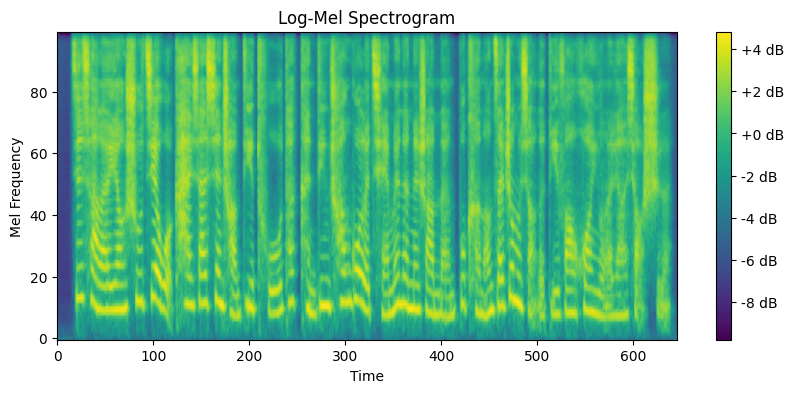

In [14]:
import librosa
import torchaudio
import numpy as np
from scipy.io.wavfile import write

def synthesize_and_process_audio(text):
    """
    整合函数，用于生成文本对应的语音，通过RVC换声，并将结果转换为梅尔频谱图。
    
    参数:
    - text: 输入文本字符串
    
    返回:
    - hidden: ChatTTS生成的隐藏特征
    - log_mel_spec: 经过RVC处理的音频的梅尔频谱图
    """
    global chat, spk_emb, vc, mel_spec  # 假设这些全局变量已初始化
    
    # 使用ChatTTS生成语音
    torch.manual_seed(SEED)
    chat_result = chat.infer_debug(text=text, params_infer_code=params_infer_code)
    audio_numpy = chat_result['wav'][0]
    hidden = chat_result['hiddens'][0]
    
    # 重采样至16kHz
    resample_audio = librosa.resample(audio_numpy, orig_sr=24000, target_sr=16000)[0]
    
    # 通过RVC换声
    audio_opt = vc_single(
        sid=0,
        audio=resample_audio,
        f0_up_key=f0_up_key,
        f0_method=f0_method,
        file_index=file_index,
        filter_radius=3,
        resample_sr=24000,
        rms_mix_rate=1,
        model_path=model_path,
        protect=0.33,
    )
    
    # 将转换后的音频转换为梅尔频谱图
    log_mel_spec = safe_log(mel_spec(torch.from_numpy(audio_opt)))
    
    return hidden, log_mel_spec.numpy()

# 使用函数
text = "接下来,杨叔，借我看一下现场地图。他肯定穿过了前面的那扇门，不可能在这么小的地方晃悠了两小时。"
hidden, log_mel_spec = synthesize_and_process_audio(text)

# 可视化Mel频谱图
plt.figure(figsize=(10, 4))
plt.imshow(log_mel_spec, aspect='auto', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [21]:
# 使用vocas模型重新转回音频信号
with torch.no_grad():
    wav = chat.pretrain_models['vocos'].decode(torch.from_numpy(log_mel_spec)[None])
Audio(wav,rate=24000)